# Set-up

In [1]:
#pip install num2words
!pip install unidecode

     |████████████████████████████████| 245kB 7.3MB/s 


In [2]:
import os
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from bs4 import BeautifulSoup
#from lxml import etree
from collections import defaultdict, Counter
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics, cluster, preprocessing
import matplotlib.pyplot as plt
import csv
import numpy as np
import random
import seaborn as sns
%matplotlib inline
from sklearn import manifold, decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble \
import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC
import timeit
import itertools
import unidecode
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive') 
import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks")
import os 
os.chdir('/content/drive/My Drive/Colab Notebooks/P6_Catégorisez automatiquement des questions')

Mounted at /content/drive


# Constantes et fonctions

In [4]:
TOP = 50
REGEX = '[a-z0-9]+[#-]?\+{0,2}[a-z0-9]*'

# Extra stopwords = radicaux qui ne me semblent pas discriminants 
EXTRA_SW = ('use', 'get', 'like', 'way', 'creat', 'would', 'want', 'need',\
            'know', 'could', 'x', 'xx', 'xyz', 'aa', 'xxx', 'z', 'yyyi', 'wont',\
            'aaa', 'aaaaaa', 'aabbc', 'aandb', 'aarrggbb', 'without', 'behind', \
            'within')

def conv_html(col):
    """
    Fonction de convertion de html en chaine standard
    """

    html = BeautifulSoup(col, 'html.parser')
    # Delete url strings
    for t in html.find_all('a'):
        t.replace_with('')
    # Delete code blocks
    for t in html.find_all('pre'):
        t.replace_with('')
    
    return html.get_text(' ', strip=True)

def clean_field(col, tknzr, sw, lmtzr, stmr):
    """
    Fonction de tokenisation du contenu dont regex \w+, 
    suppression des stopwords, lemmatisation et racinisation
    """

    temp = []
    
    for w in tknzr.tokenize(unidecode.unidecode(col).lower()):
        if w not in sw and not w.isdigit():
            pos = get_wordnet_pos(w)
            if pos != 'n':
                continue
            else:
                temp.append(stmr.stem(lmtzr.lemmatize(w, pos)))
            
    return ' '.join(temp)

def get_wordnet_pos(word):
    """
    Map POS tag to first character lemmatize() accepts
    """

    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def recap_cols(df, cols):
    """
    Fonction de dénombrement du contenu des listes des colonnes (cols) de df
    """

    print('='*50, '\nDénombrenent des mots')
    
    for col in cols:
        freq[col] = Counter(' '.join(df[col].values).split()).most_common()
        print('\t{:6s} : {:>7d} dont {:>6d} distincts'.\
                format(col, sum(dict(freq[col]).values()), len(freq[col])))
    print('='*50)
        
    return freq

# Chargement

In [7]:
freq = defaultdict()

train = pd.read_csv("db_StackOverflow.csv", header=0, encoding="ISO-8859-1", \
                    delimiter=',', quotechar='"', index_col=0, )
train.rename_axis(None, inplace=True)
train = train.apply(lambda x: x.astype(str).str.lower())
cols = train.columns[:-1]

print(train.info())

freq = recap_cols(train, cols) 

train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 27727429 to 28847860
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         50000 non-null  object
 1   Body          50000 non-null  object
 2   Tags          50000 non-null  object
 3   CreationDate  50000 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
None
Dénombrenent des mots
	Title  :  430290 dont  39376 distincts
	Body   : 7926429 dont 967125 distincts
	Tags   :   50000 dont  34345 distincts


,Title,Body,Tags,CreationDate
27727429,how to get chrome.runtime.oninstalled to fire ...,<p>i'm having problems getting some setup code...,<javascript><google-chrome><events><google-chr...,2015-01-01 00:10:29
27727590,print list names when iterating lapply,"<p>i have a time series (x,y,z and a) in a lis...",<r><lapply>,2015-01-01 00:52:04
27727629,accessing a service inside an event subscriber,<p>i have an event subscriber with doctrine ev...,<symfony><dependency-injection><lifecycle>,2015-01-01 01:05:56
27727679,app crash when i submit a new post to parse,<p>this is the only place my app crashes and o...,<android><parse-platform>,2015-01-01 01:19:47
27727690,jbutton set x location not working,<p>i have a jwindow which has a jlabel and jbu...,<java><swing><jpanel><jbutton><layout-manager>,2015-01-01 01:23:34


# Nettoyage du dataframe

In [8]:
# Stopwords nltk 
std_sw = set(nltk.corpus.stopwords.words('english')) 

tokenizer = nltk.RegexpTokenizer(REGEX)
lemmatizer = WordNetLemmatizer() 
stemmer = PorterStemmer()

print('='*50)

for col in ['Title', 'Body']:
    if col == 'Body':
        print('Conversion html de "{}" '.format(col), end='')
        start_time = timeit.default_timer()

        # Convertion du html en chaine standard 
        train[col] = train[col].apply(conv_html)

        elapsed = timeit.default_timer() - start_time
        print('-> OK en {:.3} sec'.format(elapsed))

    print('Nettoyage/lemmatisation de "{}" '.format(col), end='')
    start_time = timeit.default_timer()

    # Tokenisation et suppression des stopwords
    train[col] = train[col].apply(clean_field, tknzr=tokenizer, \
                                  sw=std_sw, lmtzr=lemmatizer, stmr=stemmer)

    # Suppression des radicaux qui ne me semblent pas discriminants (ex. use, ...)
    # et des chiffres (1, 0, 2003, ...)
    train[col] = train[col].apply(lambda x: ' '.join([w for w in x.split() \
                                                      if w not in EXTRA_SW]))

    elapsed = timeit.default_timer() - start_time
    print('-> OK en {:.3} sec'.format(elapsed))

train['full']  = train.Title + ' ' + train.Body

print('Traitement des tags ', end='')
start_time = timeit.default_timer()

# Epurage et tri des tags
train['Tags'] = train['Tags'].apply(lambda x: ' '.join(sorted(x[1:-1].split('><'))))

# Ajout du nombre de Tags 
train['nTags'] = train['Tags'].apply(lambda x: len(x.split()))

# Etiquetage des tags
#train['Tags_lbl'] = lbl.fit_transform(train.Tags)

elapsed = timeit.default_timer() - start_time
print('-> OK en {:.3} sec'.format(elapsed))

freq = recap_cols(train, cols)

print('{} groupes de tags distincts'.format(len(train.Tags.value_counts())))
print('='*50)

train.head()

Nettoyage/lemmatisation de "Title" -> OK en 48.5 sec
Conversion html de "Body" -> OK en 26.4 sec
Nettoyage/lemmatisation de "Body" -> OK en 3.56e+02 sec
Traitement des tags -> OK en 0.0837 sec
Dénombrenent des mots
	Title  :  226585 dont  15750 distincts
	Body   : 1605695 dont  59731 distincts
	Tags   :  152524 dont  11407 distincts
34269 groupes de tags distincts


,Title,Body,Tags,CreationDate,nTags
27727429,chrome runtim fire requir j chrome extens,problem setup code extens chrome runtim chrome...,events google-chrome google-chrome-extension j...,2015-01-01 00:10:29,5
27727590,print list name lappli,time seri list name dat list function list lap...,lapply r,2015-01-01 00:52:04,2
27727629,servic insid event subscrib,event subscrib doctrin event insid call servic...,dependency-injection lifecycle symfony,2015-01-01 01:05:56,3
27727679,app crash submit post pars,place app crash one featur logcat tell java la...,android parse-platform,2015-01-01 01:19:47,2
27727690,jbutton set locat,jwindow jlabel jbutton jpanel set locat jbutto...,java jbutton jpanel layout-manager swing,2015-01-01 01:23:34,5


In [34]:
train['full']  = train.Title + ' ' + train.Body

## Nombre de mots dans les Title

In [22]:
temp = pd.DataFrame()
temp['len'] = train.Title.apply(lambda x: len(x.split()))
temp.describe()

,len
count,50000.000000
mean,4.307760
std,1.723515
min,0.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,16.000000


## Nombre de mots dans les Body

In [24]:
temp = pd.DataFrame()
temp['len'] = train.Body.apply(lambda x: len(x.split()))
temp.describe()

,len
count,50000.000000
mean,31.697140
std,27.543327
min,0.000000
25%,15.000000
50%,25.000000
75%,40.000000
max,911.000000


In [25]:
backup = train.copy()

# Explorations

## Jeu de données

Text(0.5, 1.0, 'Top 50 dans Tags')

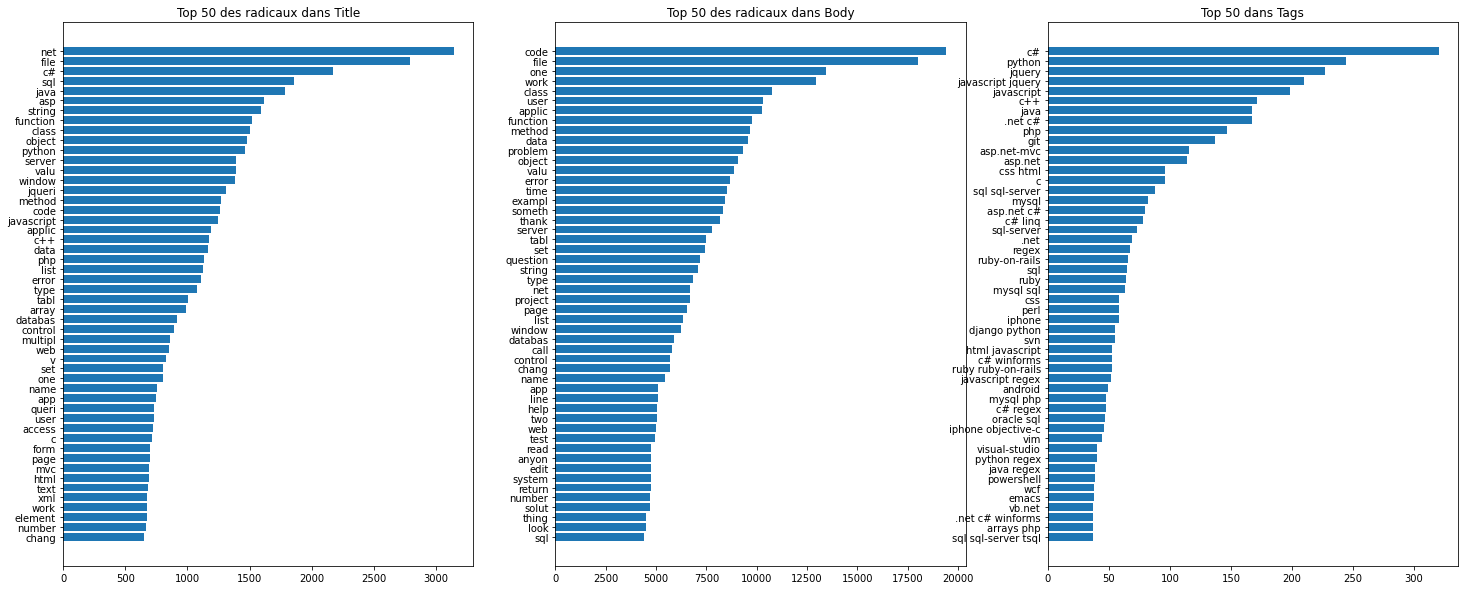

In [26]:
cpt = 0 
fig = plt.figure(figsize=(25, 10))

for col in cols[:-1]:
    cpt += 1
    plt.subplot(1, 3, cpt)
    plt.barh([k for k, v in sorted(freq[col][:TOP], key=lambda x: x[1])], 
             [v for k, v in sorted(freq[col][:TOP], key=lambda x: x[1])])
    plt.title('Top {} des radicaux dans {}'.format(TOP, col))

temp = train.Tags.value_counts().to_frame('counts')
plt.subplot(133)
plt.barh(temp.sort_values(by='counts', ascending=True)[-TOP:].index, 
         temp.sort_values(by='counts', ascending=True)[-TOP:].counts)
plt.title('Top {} dans Tags'.format(TOP))

## Top Tags

Text(0.5, 1.0, 'Distribution du nombre de tags par question')

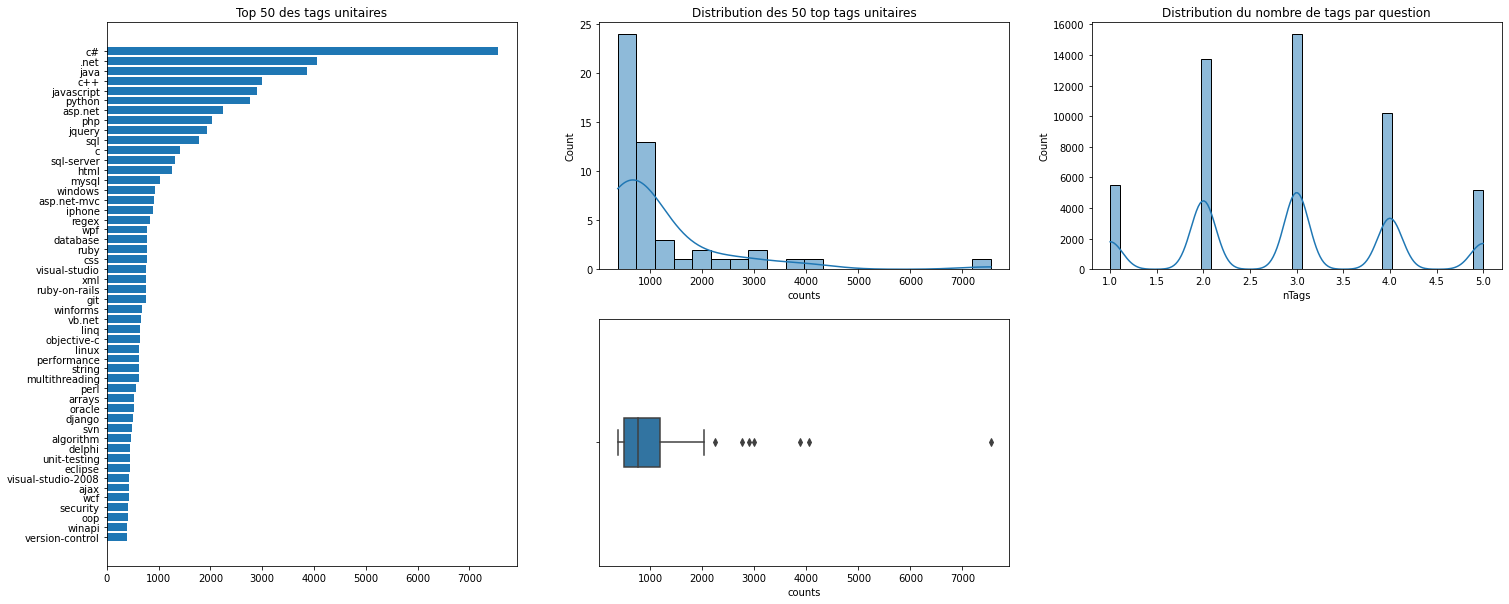

In [27]:
fig = plt.figure(figsize=(25, 10))
plt.subplot(131)
plt.barh([k for k, v in sorted(freq['Tags'][:TOP], key=lambda x: x[1])], 
         [v for k, v in sorted(freq['Tags'][:TOP], key=lambda x: x[1])])
plt.title('Top {} des tags unitaires'.format(TOP))

temp = pd.DataFrame.from_dict(dict(freq['Tags'][:TOP]), orient='index')\
                              .rename(columns={0:'counts'})
plt.subplot(232)
plt.title('Distribution des {} top tags unitaires'.format(TOP))
sns.histplot(temp.counts, kde=True)

plt.subplot(235)
sns.boxplot(x=temp.counts, width=0.2)

plt.subplot(233)
sns.histplot(train['nTags'], kde=True)
plt.title('Distribution du nombre de tags par question')

In [28]:
pd.DataFrame(freq['Tags']).rename(columns={0:'Tag', 1:'count'}).describe()

,count
count,10494.000000
mean,13.895941
std,121.763098
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,7544.000000


In [29]:
train[train.Tags.str.contains("c#")][['Title', 'Body']]

,Title,Body
16,dataset linq queri result set,linq queri asmx web servic busi tier return ty...
4,convert decim c#,track-bar chang form opac code build applic er...
61219,debug assert v thrown except,m net applic john robbin becom evangel debug a...
495351,asp net mvc rc1 renderparti,pa viewdata object master page view user contr...
846496,string behav,someon explain result two statement thought va...
...,...,...
832553,datetimepick net compact framework edit year p...,window mobil applic built c# dotnet studio for...
9868307,limit string,base64 jpeg imag string simpl signatur imag st...
881630,implement mail websit,mail function bebo facebook network site optio...
565075,set valu properti gener getter setter,sure code issu understand set properti valu so...


# Réduction de dimensions



## Tag unitaires

In [30]:
train_1T = train[train.nTags == 1]
freq = recap_cols(train_1T, cols)
print(train.shape)
train_1T.head()

Dénombrenent des mots
	Title  :   22511 dont   3576 distincts
	Body   :  142018 dont  10425 distincts
	Tags   :    5512 dont    867 distincts
(50000, 4)


,Title,Body,Tags,nTags
14646,project descript fogbugz,project edit sampl project descript project blind,fogbugz,1
34017938,decrement valu scheme,procedur n prime paramet n procedur prime rang...,scheme,1
1023055,point end file gvim,command mode gvim result someon throw bone off...,vim,1
2177008,mean rubi,mean rubi,ruby,1
368947,javascript error thrown ajaxtoolkit net machin,button save ajaxtoolkit c# net error consol st...,.net,1


Réduction aux 50 top tags

Dénombrenent des mots
	Title  :   14276 dont   2336 distincts
	Body   :   85690 dont   7206 distincts
	Tags   :    3481 dont     50 distincts


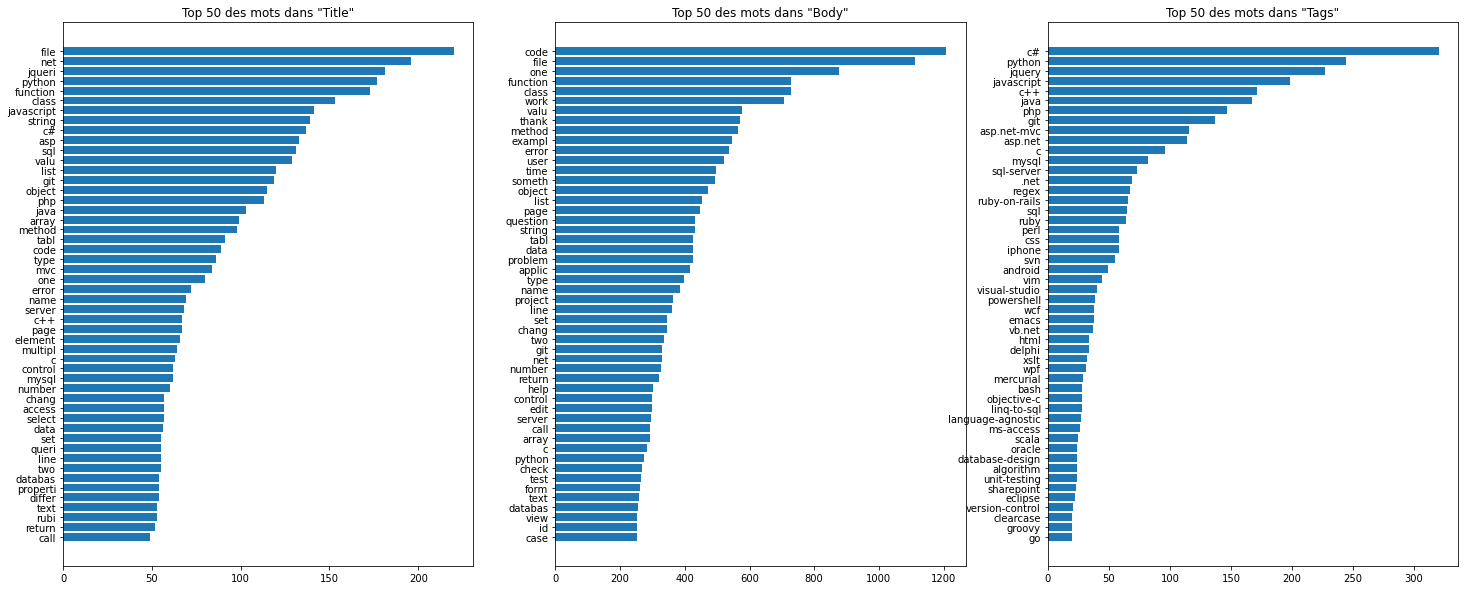

In [31]:
cpt = 1
train_1T = train_1T[train_1T.Tags.isin(dict(freq['Tags'][:TOP]).keys())]

freq = recap_cols(train_1T, cols)

fig = plt.figure(1, figsize=(25, 10))

for col in cols:
    plt.subplot(1, len(cols), cpt)
    plt.barh([k for k, v in sorted(freq[col][:TOP], key=lambda x: x[1])], 
             [v for k, v in sorted(freq[col][:TOP], key=lambda x: x[1])])
    plt.title('Top {} des mots dans "{}"'.format(TOP, col))
    cpt += 1 

# Réduction du bag of words aux 2 mots les plus féquents pour chaque tag unitaire

In [35]:
# Dictionnaire des index des enrgistrements contenant chaque tag
dict_Tags = defaultdict(dict) 

for i, c in train.iterrows():
    for t in c['Tags'].split():
        try:
            dict_Tags['idx'][t].append(i)
        except KeyError:
            dict_Tags['idx'][t] = [i]

In [36]:
# Ajout des 2 mots les plus utilisés dans TItre et Body pour chaque tag 
tag_kw = set()

for k in dict_Tags['idx'].keys():
    temp = []
    val = train[train.index.isin(dict_Tags['idx'][k])]['full']
    new = Counter(' '.join(val).split()).most_common(2)
    dict_Tags['kw'][k] = new
    for i, j in new:
        tag_kw.add(i)

print('Soit {} radicaux distincts restants'.format(len(tag_kw)))

Soit 4203 radicaux distincts restants


Dénombrenent des mots
	Title  :  193787 dont   4061 distincts
	Body   : 1315617 dont   4182 distincts
	Tags   :  145824 dont  10494 distincts


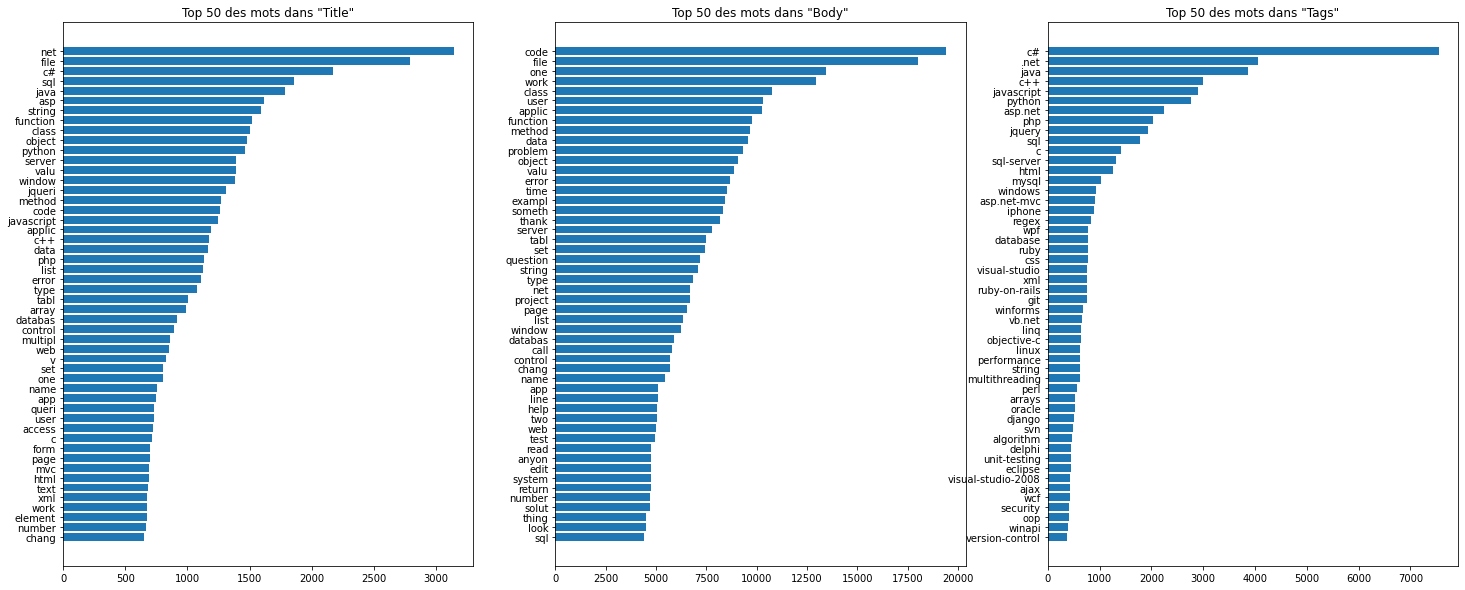

In [37]:
train2 = train.copy()
train2.Title = train2.Title.apply(lambda x: ' '.join([w for w in x.split() if w in tag_kw]))
train2.Body = train2.Body.apply(lambda x: ' '.join([w for w in x.split() if w in tag_kw]))

freq2 = recap_cols(train2, cols)

fig = plt.figure(1, figsize=(25, 10))
cpt=1
for col in cols:
    plt.subplot(1, len(cols), cpt)
    plt.barh([k for k, v in sorted(freq2[col][:TOP], key=lambda x: x[1])], 
             [v for k, v in sorted(freq2[col][:TOP], key=lambda x: x[1])])
    plt.title('Top {} des mots dans "{}"'.format(TOP, col))
    cpt += 1 

# Réduction du bag of words aux 2 mots les plus féquents pour chaque tag

In [38]:
# Dictionnaire des index des enrgistrements contenant chaque tag
dict_Tags = defaultdict(dict) 

for i, c in train.iterrows():
    try:
        dict_Tags['idx'][c['Tags']].append(i)
    except KeyError:
        dict_Tags['idx'][c['Tags']] = [i]

print('{} tags'.format(len(dict_Tags['idx'])))

36891 tags


In [39]:
# Ajout des 2 mots les plus utilisés dans TItre et Body pour chaque tag 
tag_kw = set()

for k in dict_Tags['idx'].keys():
    temp = []
    val = train[train.index.isin(dict_Tags['idx'][k])]['full']
    new = Counter(' '.join(val).split()).most_common(2)
    dict_Tags['kw'][k] = new
    for i, j in new:
        tag_kw.add(i)

print('Soit {} radicaux distincts restants'.format(len(tag_kw)))

Soit 6924 radicaux distincts restants


Dénombrenent des mots
	Title  :  204666 dont   6302 distincts
	Body   : 1438575 dont   6840 distincts
	Tags   :  145824 dont  10494 distincts


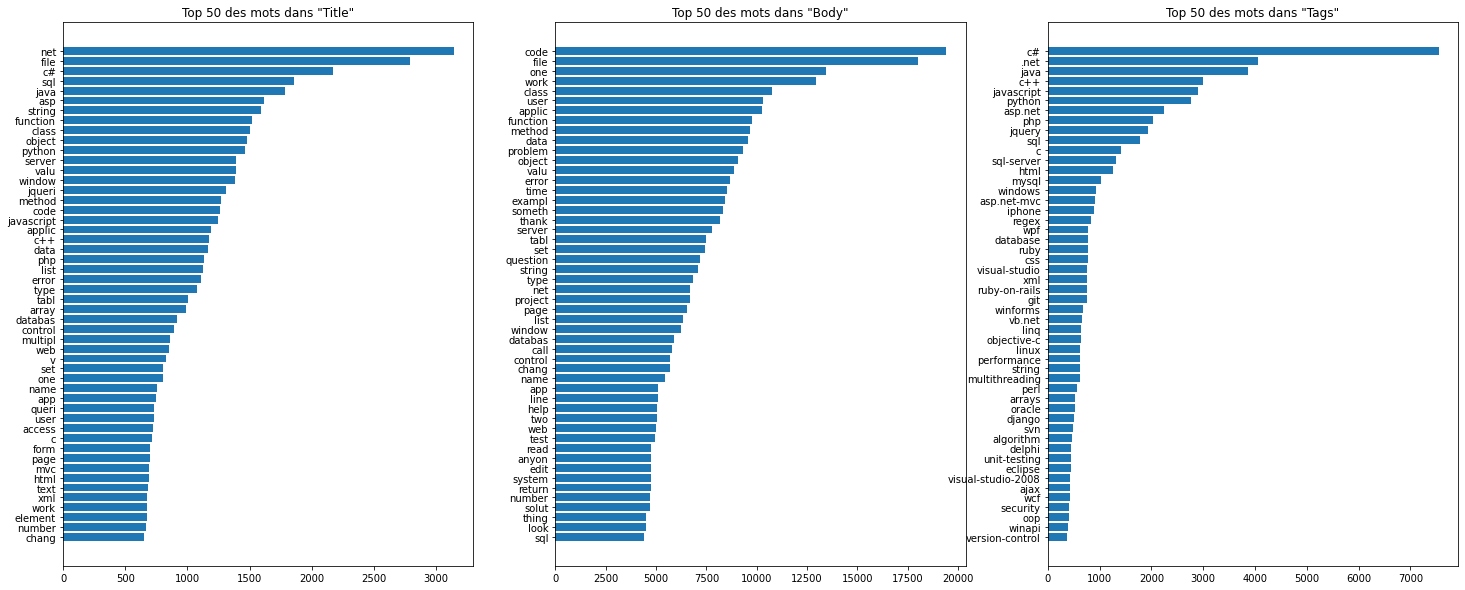

In [40]:
train2 = train.copy()
train2.Title = train2.Title.apply(lambda x: ' '.join([w for w in x.split() if w in tag_kw]))
train2.Body = train2.Body.apply(lambda x: ' '.join([w for w in x.split() if w in tag_kw]))

cols = ['Title', 'Body', 'Tags']
freq2 = recap_cols(train2, cols)

fig = plt.figure(1, figsize=(25, 10))
cpt=1
for col in cols:
    plt.subplot(1, len(cols), cpt)
    plt.barh([k for k, v in sorted(freq2[col][:TOP], key=lambda x: x[1])], 
             [v for k, v in sorted(freq2[col][:TOP], key=lambda x: x[1])])
    plt.title('Top {} des mots dans "{}"'.format(TOP, col))
    cpt += 1 

# Export

In [41]:
with open('OC_DS_P6_backup.pkl', 'wb') as file:
    pickler = pickle.Pickler(file, pickle.HIGHEST_PROTOCOL) 
    pickler.dump(train)
    pickler.dump(EXTRA_SW)

In [42]:
len(dict_Tags['kw'])

36891

In [43]:
train[train2.Tags.str.contains('emacs')]

,Title,Body,Tags,nTags,full
9390770,node j prompt show eshel,node j eshel prompt right fix,emacs eshell node.js,3,node j prompt show eshel node j eshel prompt r...
8983758,post-command hook this-command kill-word kill-...,post-command hook callback kill-word this-comm...,elisp emacs,2,post-command hook this-command kill-word kill-...
10149,bind express key combin emac,context someth emac newbi lot lisp super elisp...,emacs lisp regex,3,bind express key combin emac context someth em...
10197517,emac session client,everi c-x c-c emac announc emac session client...,emacs,1,emac session client everi c-x c-c emac announc...
1496,version vim emac mac o,u version vim emac consol version version reco...,editor emacs macos vim,4,version vim emac mac o u version vim emac cons...
...,...,...,...,...,...
589691,emul vim search gnu emac,vim key mode search word cursor gnu emac close...,dot-emacs elisp emacs vim,4,emul vim search gnu emac vim key mode search w...
970759,align argument function emac,align argument m-x align-regex align argument ...,code-formatting elisp emacs,3,align argument function emac align argument m-...
2416655,file path clipboard emac,simpl send file name file path clipboard messa...,emacs,1,file path clipboard emac simpl send file name ...
1088387,product gain vim emac provid gui text editor,meant troll flamebait anyth console-editor cho...,emacs text-editor vim,3,product gain vim emac provid gui text editor m...
